Margaux BAILLEUL 21906121 \
Cl√©mence CHESNAIS 21901191

# Sujet : Analyse de sentiments des avis des lecteurs sur des livres 

Nous avons souhait√© travailler sur la classification d‚Äôavis de livres car nous avons toutes les deux un attrait pour la lecture. Il nous a paru √©vident de travailler sur un sujet qui nous passionne car cela am√®ne une dimension personnelle au projet. 

# Choix de la base de donn√©es

Au d√©part, nous avons souhait√© utiliser une API pour r√©cup√©rer les donn√©es n√©cessaires √† notre analyse et construire nous m√™me notre base de donn√©es. Pour cela, nous nous sommes orient√©es vers des sites et applications tels que GoodReads, Google livres, Openlibrary, API fnac ou encore API Amazon. Cependant, nous avons rencontr√© des difficult√©s dans la cr√©ation des cl√©s d‚ÄôAPI. En effet, la plupart des acc√®s √©taient payants ou, dans le cas de GoodReads, la cr√©ation de cl√©s n'√©tait plus possible depuis 2020.

Notre choix s'est donc orient√© vers des bases de donn√©es d√©j√† construites. Le site Kaggle dispose d‚Äôun nombre cons√©quent de base de donn√©es tr√®s vari√©es. Apr√®s quelques recherches, nous avons eu le choix entre deux bases de donn√©es sur les avis de lecteurs : ‚ÄúFrench Book review‚Äù et ‚ÄúAmazon Books Reviews‚Äù. Cependant, cette derni√®re poss√®de un nombre tr√®s important de lignes (environ 3 millions), ce qui nous a emp√™ch√© de travailler sur celle-ci. En effet, nous avons fait le choix de travailler avec GitHub pour se partager plus facilement les codes. Or, le fichier √©tant trop lourd, il nous a √©t√© impossible de s‚Äôenvoyer et de se partager le code. Malgr√© la richesse de cette base de donn√©es, le traitement aurait pris un temps trop cons√©quent.

Ainsi, nous avons retenu la base de donn√©es ‚ÄúFrench Book Review‚Äù, sur des avis (fran√ßais) de livre.

# Import des modules

Nous allons importer tous les modules que nous allons utiliser au cours de ce projet. 

In [101]:
import pandas as pd 
import numpy as np
import regex as re
from collections import Counter
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem.snowball import FrenchStemmer 
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

Nous installons la derni√®re version de spacy ainsi que le mod√®le de langue fran√ßaise. \
Nous cr√©ons ensuite une variable nlp qui nous permet de charger le mod√®le de langue fran√ßaise pr√©alablement t√©l√©charg√©. La variable nlp devient un objet de traitement spaCy configur√© pour le fran√ßais.

In [102]:
!pip install -U spacy
!python -m spacy download fr_core_news_sm
import spacy
nlp = spacy.load('fr_core_news_sm')

     ---------------------------------------- 0.0/16.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/16.3 MB ? eta -:--:--
     --------------------------------------- 0.0/16.3 MB 325.1 kB/s eta 0:00:50
     --------------------------------------- 0.0/16.3 MB 217.9 kB/s eta 0:01:15
     --------------------------------------- 0.0/16.3 MB 217.9 kB/s eta 0:01:15
     --------------------------------------- 0.1/16.3 MB 187.0 kB/s eta 0:01:27
     --------------------------------------- 0.1/16.3 MB 182.2 kB/s eta 0:01:29
     --------------------------------------- 0.1/16.3 MB 178.6 kB/s eta 0:01:31
     --------------------------------------- 0.1/16.3 MB 178.6 kB/s eta 0:01:31
     --------------------------------------- 0.1/16.3 MB 174.7 kB/s eta 0:01:33
     --------------------------------------- 0.1/16.3 MB 173.6 kB/s eta 0:01:34
     --------------------------------------- 0.1/16.3 MB 200.1 kB/s eta 0:01:21
     --------------------------------------- 0.2/16.3 MB

# 1. Importation des donn√©es

Nous importons notre jeu de donn√©es qui s'intitule 'french_books_reviews.csv' puis nous visualisons ses 5 premi√®res lignes.

In [103]:
data = pd.read_csv('french_books_reviews.csv', sep=',')
data.head()

Unnamed: 0                          book_title                 author  \
0           0    Le D√©mon de la Colline aux Loups  Dimitri Rouchon-Borie   
1           1                              Simple      Marie-Aude Murail   
2           2  La plus secr√®te m√©moire des hommes   Mohamed Mbougar Sarr   
3           3                            Trancher      Am√©lie Cordonnier   
4           4            La guerre d'Alan, tome 2       Emmanuel Guibert   

                                       reader_review  rating  label  
0  Ce n'est pas le premier roman √† aborder les th...     5.0      1  
1  Simple, alias Barnab√©, est un jeune homme de 2...     4.0      1  
2  Pour √©crire La plus secr√®te m√©moire des hommes...     4.0      1  
3  ¬´¬†La violence d'Aur√©lien est revenue. Par la f...     3.5      0  
4  Dans ce second album de La Guerre d‚ÄôAlan, Emma...     5.0      1

Dans ce jeu de donn√©es nous disposons de 3 variables qualitatives et 2 variables quantitatives. 
Pour notre √©tude, nous avons le titre du livre, les noms et pr√©noms des auteurs, l'avis du lecteur, la note qu'il a attribu√© au livre ainsi qu'un label correspondant √† la polarit√© de l'avis. Si l'avis est positif, le label vaut 1, s'il est neutre, il vaut 0 et s'il est n√©gatif, il vaut -1. \
Notons que les noms des livres ainsi que les commentaires sont bien en fran√ßais.

## 1.1. Statistiques descriptives

Tout d'abord, nous commen√ßons par regarder si la base de donn√©es contient des valeurs manquantes.

In [104]:
data["reader_review"].isna().sum()

13

13 lignes contiennent des valeurs manquantes. Nous d√©cidons de les supprimer car elles ne repr√©sentent que 0.1% de la base de donn√©es.
De plus, nous souhaitons √©tudier les avis des clients, il n'y a donc pas d'int√©r√™t √† garder les lignes o√π il n'y a pas d'avis.

In [105]:
data = data.dropna(subset=['reader_review'])

Nous v√©rifions qu'il ne reste plus de ligne sans avis.

In [106]:
data["reader_review"].isna().sum()

0

Nous regardons maintenant le nombre d'avis pour chacune des polarit√©s.

In [107]:
data["label"].value_counts()

polarity_distribution= (pd.DataFrame.from_dict(Counter(data.label.values),
                                             orient='index')
                                  .rename(columns={0: 'nb_reviews'}))
polarity_distribution.index.name = 'class'
polarity_distribution

nb_reviews
class            
 1           6658
 0           2129
-1            858

Dans ce jeu de donn√©es, il y a 6658 positifs, 2129 neutres et 858 n√©gatifs.

Ensuite, nous allons calculer le pourcentage d'avis pour chaque polarit√©.

In [108]:
polarity_distribution['pourcentage'] = np.around(polarity_distribution.nb_reviews /
                                                np.sum(polarity_distribution.nb_reviews),
                                                2)
polarity_distribution

nb_reviews  pourcentage
class                         
 1           6658         0.69
 0           2129         0.22
-1            858         0.09

Nous repr√©sentons sur un graphique la distributions des polarit√©s selon le nombre d'avis.

<Axes: title={'center': "Nombre d'avis par classe"}, xlabel='class'>

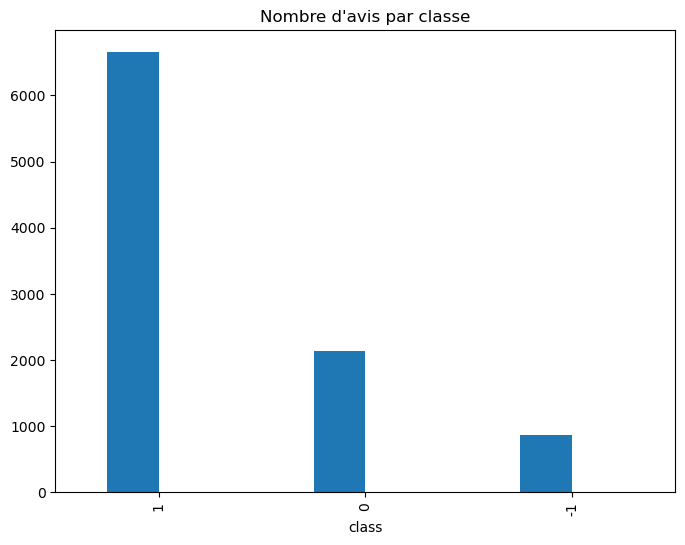

In [109]:
polarity_distribution.plot(kind='bar', figsize=(8, 6), legend=False, 
                           title="Nombre d'avis par classe")

Graphiquement, nous observons bien qu'il y a beaucoup plus d'avis positifs que d'avis neutres ou n√©gatifs.

Nous affichons les 10 premiers avis pour voir √† quoi ressemble les donn√©es.


In [110]:
for i in list(data['reader_review'][0:10]):
    print(i)
    print('------------------------')

Ce n'est pas le premier roman √† aborder les th√®mes lourds de l'inceste et de l'enfance martyre, mais il le fait avec une audace et un brio incomparables qui rendent ce livre marquant dans une vie de lecteur. On y sent √† quel point l'auteur n'a pas cherch√© √† "faire quelque chose", on ne sent jamais l'intention, on sent juste l'urgence, incandescente, √† raconter la v√©rit√© d'un homme maltrait√© par la vie au point de dire √† la nuit ¬´¬† tu ne me feras pas peur j'ai plus de noir que toi dans mon enfance¬†¬ª.
------------------------
Simple, alias Barnab√©, est un jeune homme de 22 ans qui a l‚Äô√¢ge mental d‚Äôun enfant de 3 ans. Kl√©ber, son fr√®re de 17 ans, entre en terminale au lyc√©e, mais d√©cide de s‚Äôoccuper lui-m√™me de son fr√®re. Leur m√®re √©tant morte et leur p√®re refusant de s‚Äôencombrer de sa prog√©niture afin de vivre pleinement sa nouvelle vie, Kl√©ber refuse d‚Äôabandonner son fr√®re √† Malicroix, l‚Äôinstitution o√π il d√©p√©rissait. Se mettant tant bien que 

On remarque que certains avis ne sont pas r√©ellement des avis mais un r√©sum√© du livre ou une citation de celui-ci. Ces derniers devraient √™tre class√© dans la cat√©gorie neutre.

## 1.2. S√©paration des donn√©es

Nous s√©parons les donn√©es en deux jeux de donn√©es : un jeu d'entrainement et un jeu de test.

In [111]:
# On m√©lange les lignes du DataFrame
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# On utilise la fonction train_test_split pour diviser le DataFrame
train_df, test_df = train_test_split(data, train_size=2/3, random_state=42)

# On affiche les informations sur les ensembles d'entra√Ænement et de test
print("Taille de l'ensemble d'entra√Ænement :", len(train_df))
print("Taille de l'ensemble de test :", len(test_df))

Taille de l'ensemble d'entra√Ænement : 6430
Taille de l'ensemble de test : 3215


# 2. Pr√©traitement des donn√©es

## 2.1 Lemmatisation

Lemmatiser un texte implique de r√©duire chaque mot √† sa forme de base ou √† son "lemme".
Cela implique la suppression des variations grammaticales (comme les temps verbaux, les genres, les nombres, etc.) pour regrouper les mots qui ont la m√™me signification de base. 

La lemmatisation est souvent utilis√©e pour am√©liorer la pr√©cision de l'analyse en r√©duisant les variations de mots √† leur forme canonique. Cela aide √† regrouper les mots apparent√©s et √† r√©duire la complexit√© lors de l'analyse textuelle. 

In [112]:
def lemmatisation(text):
    text = nlp(text)
    lemmas = [token.lemma_ for token in text]
    return ' '.join(lemmas)

On applique la lemmatisation sur les avis des livres des jeux de donn√©es d'aprentissage et de test. Le r√©sultat de cette lemmatisation sera stock√© dans une nouvelle colonne. 

In [113]:
train_df['lemme'] = train_df['reader_review'].apply(lemmatisation)

In [114]:
for i in list(train_df['lemme'][0:5]):
    print(i)
    print('------------------------')

le 26√®m opus de aventure de San antonio r√©unir avec son acolyte pr√©f√©rer , B√©rurier et Pinaud ( qui en prennent pour son grade de ailleurs ) ne figurer pas dans le meilleur de le s√©rie . le enqu√™te se d√©rouler √† Paris en partir de Halles , en passer par un bureau de Poste , le commissariat et quelque h√¥tel . un classique de le √©poque dire on , un investigation sur quelque jour dans le capitale et notre commissaire qui ne h√©sit pas √† se salir le main pour d√©couvrir le v√©rit√© . quant aux femme .... lui ne appr√©cier pas ce tome !
------------------------
¬´ ¬†  mais alors ! le p√®re No√´l exister -t il ? ¬† ¬ª , pour - raton se demander √† le lecture de ce guide qui donne envie de s‚Äô offrir enfin √† soi - m√™me de cadeau utile ? pouvoir - √™tre , mais ce qu‚Äô il y avoir de certain , c‚Äô √™tre qu‚Äô on y parler tr√®s peu de le m√®re No√´l qui avoir perdre son ch√¢le .
------------------------
je retrouver avec beaucoup de joie l‚Äô auteure , Marjane satrapi m‚Äô avoir 

Nous faisons la m√™me chose pour le jeu de donn√©es de test.

In [115]:
test_df['lemme'] = test_df['reader_review'].apply(lemmatisation)

In [116]:
for i in list(test_df['lemme'])[0:5]:
    print(i)
    print('------------------------')

troisi√®me aventure de Tori et son mage .
------------------------
et s‚Äô il falloir choisir celui qui √™tre sauver ?
------------------------
se attaquer √† 667 page ( dense ) de ce biographie de Fouch√© pouvoir appara√Ætre comme un challenge . mais le talent de historien de Emmanuel de Waresquiel avoir vite faire de donner le envie de parcourir ce ouvrage avec d√©termination !
------------------------
ce ouvrage plaire √† petit comme √† grand , √† adepte de beal livre illustrer comme √† sorci√®re et sorcier en herbe .
------------------------
livre fantastique remplir de √©motion de d√©but √† le fin . le lecture de un chapitre me donner envie de conna√Ætre le suite . je avoir d√©vorer ce livre . par contre , quand le fin arriver , quel tristesse de laisser ce personnage . je avoir envier de continuer un petit bout de chemin avec lui .
------------------------


Nous remarquons que la lemmatisation a bien fonctionn√©.

## 2.2. Racine des mots

Nous rempla√ßons les mots par leur racine. Cela permet de r√©duire la complexit√© lors de l'analyse textuelle.

In [117]:
def stem_text(text):
    tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
    stemmer = FrenchStemmer('french')
    stems = [stemmer.stem(token) for token in tokenizer.tokenize(text)]
    return ' '.join(stems)

De la m√™me mani√®re, nous cr√©ons une nouvelle colonne qui contiendra le texte racinis√©. 

In [118]:
train_df['stems'] = train_df['reader_review'].apply(stem_text)

In [119]:
for i in list(train_df['stems'])[0:5]:
    print(i)
    print('------------------------')

le 26em opus des aventur de san antonio r√©un avec ses acolyt pr√©fer , b√©ruri et pinaud ( qui en prennent pour leur grad d'ailleur ) ne figur pas dans les meilleur de la ser . l'enqu√™t se d√©roul √† paris en part des hall , en pass par des bureau de post , le commissariat et quelqu h√¥tel . un classiqu de l'√©poqu dir on , des investig sur quelqu jour dans la capital et notre commissair qui n'h√©sit pas √† se sal les main pour d√©couvr la v√©rit . quant aux femm ... elle n'appr√©ci pas ce tom !
------------------------
¬´ mais alor ! le per no√´l existera-t-il ? ¬ª , pour-raton se demand √† la lectur de ce guid qui don envi de s ‚Äô offrir enfin √† soi-m√™m des cadeau util ? peut-√™tr , mais ce qu ‚Äô il y a de certain , c ‚Äô est qu ‚Äô on y parl tres peu de la mer no√´l qui a perdu son ch√¢l .
------------------------
je retrouv avec beaucoup de joi l ‚Äô auteur , marjan satrap m ‚Äô avait √©blou par sa matur dans pers√©pol et je la retrouv tout auss excellent dans poulet aux prun

Nous faisons la m√™me chose pour le jeu de donn√©es de test.

In [120]:
test_df['stems'] = test_df['reader_review'].apply(stem_text)

In [121]:
for i in list(test_df['stems'][0:5]):
    print(i)
    print('------------------------')

troisiem aventur de tor et ses mag .
------------------------
et s ‚Äô il fall chois ceux qui seraient sauv ?
------------------------
s'attaqu aux 667 pag ( dens ) de cet biograph de fouch peut appara√Ætr comm un challeng . mais le talent d'historien d'emmanuel de waresquiel a vit fait de don l'env de parcour cet ouvrag avec d√©termin !
------------------------
cet ouvrag plair aux petit comm aux grand , aux adept de beau livr illustr comm aux sorci et sorci en herb .
------------------------
livr fantast rempl d'√©mot du d√©but √† la fin . la lectur d'un chapitr me don envi de conna√Ætr la suit . j'ai d√©vor ce livr . par contr , quand la fin arriv , quel tristess de laiss ces personnag . j'av envi de continu un pet bout de chemin avec eux .
------------------------


Nous remarquons bien que la racinisation a fonctionn√©. Nous remarquons √©galement la diff√©rence avec la lemmatisation. 

## 2.3. Etiquetage morphosyntaxique

Cela va nous permettre d'attribuer des √©tiquettes grammaticales √† chaque mot dans une phrase, indiquant ainsi leur cat√©gorie grammaticale ou leur r√¥le dans la phrase. 

In [122]:
def replace_words_with_pos_tag(text):
    text = nlp(text)
    return ' '.join([token.pos_ for token in text])

In [123]:
train_df['pos'] = train_df['reader_review'].apply(replace_words_with_pos_tag)

In [124]:
for i in list(train_df['pos'][0:5]):
    print(i)
    print('------------------------')

DET ADJ NOUN ADP NOUN ADP PROPN NOUN VERB ADP DET NOUN VERB PUNCT PROPN CCONJ PROPN PUNCT PRON PRON NOUN ADP DET NOUN ADP ADV PUNCT ADV VERB ADV ADP DET NOUN ADP DET NOUN PUNCT DET NOUN PRON VERB ADP PROPN ADP VERB ADP PROPN PUNCT ADP VERB ADP DET NOUN ADP PROPN PUNCT DET NOUN CCONJ DET NOUN PUNCT DET NOUN ADP DET NOUN VERB PRON PUNCT DET NOUN ADP DET NOUN ADP DET NOUN CCONJ DET NOUN PRON ADV ADJ ADV ADP PRON VERB DET NOUN ADP VERB DET NOUN PUNCT ADV DET NOUN PUNCT PRON ADV VERB ADV DET NOUN PUNCT
------------------------
ADJ SPACE CCONJ ADV PUNCT DET NOUN PROPN AUX PRON PRON PUNCT SPACE PUNCT PUNCT ADP PROPN ADJ PRON VERB ADP DET NOUN ADP DET NOUN PRON VERB NOUN ADP PROPN VERB ADV ADP PRON ADV ADV ADP NOUN ADJ PUNCT ADV ADV ADV PUNCT CCONJ PRON PROPN PRON PRON VERB ADP ADJ PUNCT NOUN AUX SCONJ PRON PRON VERB ADV ADV ADP DET NOUN PROPN PRON AUX VERB DET NOUN PUNCT
------------------------
PRON VERB ADP ADV ADP VERB ADJ VERB PUNCT PROPN DET NOUN AUX VERB ADP DET NOUN ADP PROPN CCONJ PRO

Nous faisons la m√™me chose pour le jeu de donn√©es de test.

In [125]:
test_df['pos'] = test_df['reader_review'].apply(replace_words_with_pos_tag)

In [126]:
for i in list(test_df['pos'][0:5]):
    print(i)
    print('------------------------')

ADJ NOUN ADP PROPN CCONJ DET NOUN PUNCT
------------------------
CCONJ PRON PRON VERB NOUN PRON PRON AUX VERB PUNCT
------------------------
PRON VERB ADP NUM NOUN PUNCT ADJ PUNCT ADP DET NOUN ADP PROPN VERB VERB ADP DET NOUN PUNCT CCONJ DET NOUN ADP NOUN ADP PROPN ADP PROPN AUX ADV VERB ADP VERB DET NOUN ADP VERB DET NOUN ADP NOUN PUNCT
------------------------
DET NOUN VERB ADP ADJ ADP ADP NOUN PUNCT ADP NOUN ADP ADJ NOUN VERB ADP ADP NOUN CCONJ ADJ ADP NOUN PUNCT
------------------------
NOUN ADJ VERB ADP NOUN ADP NOUN ADP DET NOUN PUNCT DET NOUN ADP DET NOUN PRON VERB NOUN ADP VERB DET NOUN PUNCT PRON AUX VERB DET NOUN PUNCT ADP NOUN PUNCT SCONJ DET NOUN VERB PUNCT DET NOUN ADP VERB DET NOUN PUNCT PRON VERB VERB ADP VERB DET ADJ NOUN ADP NOUN ADP PRON PUNCT
------------------------


## 2.4. Entit√©s nomm√©es

Les entit√©s nomm√©es sont des √©l√©ments sp√©cifiques dans un texte qui font r√©f√©rence √† des personnes, des lieux, des organisations, des dates, des quantit√©s, etc. L'identification et l'√©tiquetage des entit√©s nomm√©es sont essentiels dans le traitement automatique du langage naturel pour pouvoir extraire des informations cl√©s d'un texte. 

Par exemple, dans un article de presse, rep√©rer les noms des personnes, des lieux ou des organisations est crucial pour comprendre le contenu et ses acteurs.

In [127]:
def ner(text):
    text = nlp(text)
    new_text = []
    for token in text:
        if token.ent_iob_ == "O":
            new_text.append(token.text)
        elif token.ent_iob_ == "B":
            new_text.append(token.ent_type_)
        # Si l'entit√© comprend plusieurs mot on ne r√©p√®te pas l'√©tiquette
        else:
            continue
    return ' '.join(new_text)

Pour expliquer cette fonction, nous prenons l'exemple avec la phrase suivante :
"Elle vit √† Paris et travaille chez Google. Elle a rencontr√© John Doe √† New York."

La fontion pour chaque mot donne le r√©sultat suivant :

- "Elle" : "O" (Outside), car ce mot ne fait pas partie d'une entit√© nomm√©e.

- "vit" : "O" (Outside), pas une entit√© nomm√©e.

- "√†" : "O" (Outside), pas une entit√© nomm√©e.

- "Paris" :"B" (Beginning) et ent_type_ = "LIEU" , car c'est le d√©but d'une entit√© nomm√©e de type "LIEU".

- "et" : "O" (Outside), pas une entit√© nomm√©e.

- "travaille" : "O" (Outside), pas une entit√© nomm√©e.

- "chez" : "O" (Outside), pas une entit√© nomm√©e.

- "Google" : "B" (Beginning) et ent_type_ = "ORGANISATION", car c'est le d√©but d'une entit√© nomm√©e de type "ORGANISATION".

- "." : "O" (Outside), pas une entit√© nomm√©e.

- "Elle" : "O" (Outside), pas une entit√© nomm√©e.

- "a" : "O" (Outside), pas une entit√© nomm√©e.

- "rencontr√©" : "O" (Outside), pas une entit√© nomm√©e.

- "John" : "B" (Beginning) et ent_type_ = "PERSONNE", car c'est le d√©but d'une entit√© nomm√©e de type "PERSONNE".

- "Doe" : "I" (Inside) et ent_type_ = "PERSONNE", car c'est la suite d'une entit√© nomm√©e de type "PERSONNE".

- "√†" : "O" (Outside), pas une entit√© nomm√©e.

- "New" : "B" (Beginning) et ent_type_ = "LIEU", car c'est le d√©but d'une entit√© nomm√©e de type "LIEU".

- "York" : "I" (Inside) et ent_type_ = "LIEU", car c'est la suite d'une entit√© nomm√©e de type "LIEU".

- "." : "O" (Outside), pas une entit√© nomm√©e.


Les entit√©s de type I ne sont pas affich√©es.
Pour les mots de type B, ils seront remplac√©es par le type de l'entit√© nomm√©e. Par exemple, "Paris" sera remplac√© par "LIEU".

On aura donc la phrase suivante :

"Elle vit √† LIEU et travaille chez ORGANISATION. Elle a rencontr√© PERSONNE √† LIEU."

Nous appliquons cette fonction sur les jeux de donn√©es d'apprentissage et de test.

In [128]:
train_df['entites_nommees'] = train_df['reader_review'].apply(ner)

In [129]:
for i in list(train_df['entites_nommees'][0:5]):
    print(i)
    print('------------------------')

Le 26√®me opus des aventures de San Antonio r√©uni avec ses acolytes pr√©f√©r√©s , PER et PER ( qui en prennent pour leur grade d' ailleurs ) ne figure pas dans les meilleurs de la s√©rie . L' enqu√™te se d√©roule √† LOC en partant des LOC , en passant par des bureaux ORG , le commissariat et quelques h√¥tels . Un classique de l' √©poque dirait on , des investigations sur quelques jours dans la capitale et notre commissaire qui n' h√©site pas √† se salir les mains pour d√©couvrir la v√©rit√© . Quant aux femmes .... elle n' appr√©cieront pas ce tome !
------------------------
¬´ ¬†  Mais alors ! Le p√®re MISC existera -t -il ? ¬† ¬ª , pour - raton se demander √† la lecture de ce guide qui donne envie de PER offrir enfin √† soi - m√™me des cadeaux utiles ? Peut - √™tre , mais ce qu‚Äô il y a de certain , MISC est LOC on y parle tr√®s peu de la m√®re MISC qui a perdu son ch√¢le .
------------------------
Je retrouve avec beaucoup de joie l‚Äô auteure , MISC PER avait √©bloui par sa maturi

In [130]:
test_df['entites_nommees'] = test_df['reader_review'].apply(ner)

In [131]:
for i in list(test_df['entites_nommees'][0:5]):
    print(i)
    print('------------------------')

Troisi√®me aventure de LOC et ses mages .
------------------------
Et LOC il fallait choisir ceux qui seraient sauv√©s ?
------------------------
S' attaquer aux 667 pages ( denses ) de cette biographie de PER peut appara√Ætre comme un challenge . Mais le talent d' historien d' PER a vite fait de donner l' envie de parcourir cet ouvrage avec d√©termination !
------------------------
Cet ouvrage plaira aux petits comme aux grands , aux adeptes de beaux livres illustr√©s comme aux sorci√®res et sorciers en herbe .
------------------------
livre fantastique rempli d' √©motions du d√©but √† la fin . la lecture d' un chapitre me donnait envie de conna√Ætre la suite . j' ai d√©vor√© ce livre . par contre , quand la fin arrive , quelle tristesse de laisser ces personnages . j' avais envie de continuer un petit bout de chemin avec eux .
------------------------


## 2.5. Traitement des URLS 

Nous rempla√ßons les URL par un mot fictif. En effet, les URL peuvent poser probl√®me dans l'apprentissage du mod√®le. C'est pourquoi nous les rempla√ßons par un mot unique choisi au pr√©alable.

In [132]:
def remplacer_url(text, url_replacement='urlexpr'):
    text = re.sub(r'https?:\S+', url_replacement, text) # http://t.co/eFKkE9W0GI
    text = re.sub(r'\bwww\.\S+', url_replacement, text) # www.example.com
    return text

In [133]:
train_df['sans_url'] = train_df['reader_review'].apply(remplacer_url)

In [134]:
for i in list(train_df["sans_url"][0:5]):
    print(i)
    print('------------------------')

Le 26√®me opus des aventures de San Antonio r√©uni avec ses acolytes pr√©f√©r√©s, B√©rurier et Pinaud (qui en prennent pour leur grade d'ailleurs) ne figure pas dans les meilleurs de la s√©rie. L'enqu√™te se d√©roule √† Paris en partant des Halles, en passant par des bureaux de Poste, le commissariat et quelques h√¥tels. Un classique de l'√©poque dirait on, des investigations sur quelques jours dans la capitale et notre commissaire qui n'h√©site pas √† se salir les mains pour d√©couvrir la v√©rit√©. Quant aux femmes.... elle n'appr√©cieront pas ce tome !
------------------------
¬´¬† Mais alors ! Le p√®re No√´l existera-t-il ?¬†¬ª, pour-raton se demander √† la lecture de ce guide qui donne envie de s‚Äôoffrir enfin √† soi-m√™me des cadeaux utiles ? Peut-√™tre, mais ce qu‚Äôil y a de certain, c‚Äôest qu‚Äôon y parle tr√®s peu de la m√®re No√´l qui a perdu son ch√¢le.
------------------------
Je retrouve avec beaucoup de joie l‚Äôauteure, Marjane Satrapi m‚Äôavait √©bloui par sa maturit√

Nous faisons la m√™me chose pour le jeu de donn√©es de test.

In [135]:
test_df['sans_url'] = test_df['reader_review'].apply(remplacer_url)

In [136]:
resultats = test_df[test_df['sans_url'].str.contains('urlexpr')]
resultats['sans_url']

1287                                       Insta: urlexpr
604     Si ce roman promettait d'√™tre ing√©nieux et ori...
Name: sans_url, dtype: object

Nous voyons bien que les liens sont √©t√© remplac√©s par 'urlexp'.  

## 2.6 Suppression de certains mots

La suppression de certains mots comme les "mots vides", c'est-√†-dire les mots qui n'apportent pas d'information pour la classification, permettent de se focaliser sur les mots les plus importants. Par exemple, les mots "et", "car", "le", "la"... n'apportent pas d'information. 
De plus, les mod√®les d'analyse de sentiments peuvent √™tre sensibles √† la dimensionnalit√© √©lev√©e des donn√©es. 

En r√©duisant le vocabulaire, on r√©duit le nombre de mots que le mod√®le doit prendre en compte, ce qui peut am√©liorer l'efficacit√© de l'apprentissage et la vitesse d'entra√Ænement.
Certains mots peuvent appara√Ætre rarement ou √™tre sp√©cifiques √† des documents particuliers, ce qui peut introduire du bruit dans le mod√®le. 
Par ailleurs, en se concentrant sur les termes les plus fr√©quents et les plus informatifs, le mod√®le peut se g√©n√©raliser plus efficacement √† de nouveaux textes. Cela peut √©galement contribuer √† √©viter le surajustement aux donn√©es d'entra√Ænement.


In [137]:
sw = nltk.corpus.stopwords.words('french')
print(sw)

['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'm√™me', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', '√†', 'm', 'n', 's', 't', 'y', '√©t√©', '√©t√©e', '√©t√©es', '√©t√©s', '√©tant', '√©tante', '√©tants', '√©tantes', 'suis', 'es', 'est', 'sommes', '√™tes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', '√©tais', '√©tait', '√©tions', '√©tiez', '√©taient', 'fus', 'fut', 'f√ªmes', 'f√ªtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'f√ªt', 'fussions', 'fussiez', 'fussent', 'ayant', 'ayante', 'ayantes', 'ayants', 'eu', 'eue', 'eues', 'eus', 'ai', 'as', 'avons', 'avez', 'ont', 'aurai', 'auras',

Nous appliquerons ce corpus de mots vides √† nos jeux de donn√©es d'apprentissage et de test dans la suite de notre √©tude.

# 3. Calcul des valeurs des descripteurs

## 3.1. S√©paration du jeu de donn√©es d'entrainement en 2 jeux de donn√©es

Nous s√©parons le jeu de donn√©es d'entrainement en 2 jeux de donn√©es : un jeu de donn√©es d'entrainement et un jeu de donn√©es de validation. 

# FAIRE JUSTIFICATION DU CHOIX DE LA COLONNE ENTITE NOMMEES

In [138]:
from sklearn.model_selection import train_test_split

In [139]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df['reader_review'],
                                                      train_df['label'],
                                                      train_size=0.75,
                                                      random_state=5)

Pour le jeu de donn√©es tests, on met la variable label dans un objet "y_test" et la colonne "reader_review" dans un objet "X_test".

In [140]:
X_test, y_test = test_df['reader_review'], test_df['label']

## 3.2 Num√©rique discret : d√©compte d'occurences

La fonction CountVectorizer permet de compter le nombre d'occurences de chaque mot dans chaque avis. Elle transforme une liste de textes en une repr√©sentation num√©rique utilisable pour des algorithmes d'apprentissage automatique.

Le processus de fit consiste √† analyser le texte pour d√©terminer les mots uniques pr√©sents dans X_train et √† cr√©er une repr√©sentation vectorielle de ces mots. Chaque texte sera repr√©sent√© comme un vecteur o√π chaque √©l√©ment correspond √† la fr√©quence d'apparition de chaque mot du vocabulaire dans ce texte.

Ainsi, cela cr√©√© un objet "CountVectorizer" qui contient le vocabulaire de tous les mots de tous les avis.\ Cet objet est appel√© "vect_count".

In [141]:
vect_count = CountVectorizer().fit(X_train)

On affiche les 50 premiers noms des mots utilis√©s pour cr√©er la repr√©sentation vectorielle des textes :

In [142]:
vect_count.get_feature_names_out()[:50]

array(['000', '02', '03', '08', '10', '100', '1000', '1078', '109', '11',
       '112', '115', '12', '1200', '121', '125', '12ans', '12heures',
       '13', '130', '130kg', '130p', '14', '140', '141', '1415', '1425',
       '144', '14ans', '15', '150', '1518', '153', '15jours', '16', '160',
       '1600', '1604', '1613', '1615', '164', '165', '1664', '1665',
       '1691', '16√®me', '17', '173', '1750', '1756'], dtype=object)

On affiche les 50 derniers noms des mots utilis√©s pour cr√©er la repr√©sentation vectorielle des textes :

In [143]:
vect_count.get_feature_names_out()[-50:]

array(['√©voqu√©e', '√©voqu√©es', '√©voqu√©s', '√©v√®nement', '√©v√®nementielle',
       '√©v√®nements', '√©v√©nement', '√©v√©nements', '√™kho', '√™tes', '√™tre',
       '√™tres', '√Æle', '√Æles', '√Ønes', '√¥shi', '√¥te', '√∂rn', '≈ìdipe',
       '≈ìdipienne', '≈ìil', '≈ìils', '≈ìuf', '≈ìufs', '≈ìuvre', '≈ìuvrent',
       '≈ìuvres', '≈ìuvr√©', '–¥–æ—Å—Ç–æ–µ–≤—Å–∫–∏–π', '–º–∏—Ö–∞–π–ª–æ–≤–∏—á', '—Ñ—ë–¥–æ—Ä', 'Êó•ÂÖâÊµÅÂπ¥',
       'ÈòéËøûÁßë', 'ùêªùëíùëéùëüùë°ùë†', 'ùêΩùëí', 'ùëÅùëúùëí', 'ùëáùëéùëñùëõùë°ùëíùëë', 'ùëéùëñùëöùëíùëü', 'ùëìùëíùëüùëéùëñùë†', 'ùë°ùëí',
       'ùóüùóÆ', 'ùó∞ùóµùóºùòÄùó≤', 'ùó±ùó∂ùòÄùóΩùóºùòÄùó≤ùòÄ', 'ùó≤ùóª', 'ùó≤ùòÅ', 'ùóΩùóøùóºùóΩùóºùòÄùó≤', 'ùóæùòÇùó≤ùóπùóæùòÇùó≤', 'ùòÅùó≤',
       'ùòÅùòÇ', 'ùòÉùó∂ùó≤'], dtype=object)

In [144]:
len(vect_count.get_feature_names_out())

23492

Ainsi, nous cr√©ons une repr√©sentation vectorielle des donn√©es d'entra√Ænement en se basant sur le vocabulaire √©tabli pr√©c√©demment. 

Donc, cette op√©ration convertit les donn√©es textuelles en une matrice num√©rique o√π chaque ligne correspond √† un texte et chaque colonne correspond √† la fr√©quence d'un mot sp√©cifique dans ce texte.

In [145]:
X_train_vectorized_count = vect_count.transform(X_train)
X_train_vectorized_count

<4822x23492 sparse matrix of type '<class 'numpy.int64'>'
	with 192491 stored elements in Compressed Sparse Row format>

X_train_count est une matrice de taille (n_train=4822, n_features=18634) o√π n_train est le nombre de textes dans le jeu de donn√©es d'entra√Ænement et n_features est le nombre de mots dans le vocabulaire.

Nous faisons la m√™me chose pour le jeu de donn√©es de validation et de test :

In [146]:
X_valid_vectorized_count = vect_count.transform(X_valid)
X_test_vectorized_count = vect_count.transform(X_test)

Nous cr√©ons un autre objet CountVectorizer mais cette fois-ci, nous posons certaines conditions : le mot doit apparaitre au moins 5 fois dans les documents pour √™tre inclus dans le vocabulaie. De plus, les mots seront des unigrammes et des bigrammes.

In [147]:
vect_count_bigrams = CountVectorizer(min_df=5, ngram_range=(1,2)).fit(X_train)
X_train_vectorized_count_bigrams = vect_count_bigrams.transform(X_train)
X_valid_vectorized_count_bigrams = vect_count_bigrams.transform(X_valid)
X_test_vectorized_count_bigrams = vect_count_bigrams.transform(X_test)

In [148]:
len(vect_count_bigrams.get_feature_names_out())

10483

Le nombre de mots dans le vocabulaire a diminu√© du fait des conditions ajout√©es dans le CountVectorizer. Il est pass√© d'environ 18 600 √† environ 10 000. 

## 3.3 Num√©rique continu : TF-IDF

Nous avons d√©cid√© de cr√©er 2 objets tfidfVectorizer : un avec le param√®tre stopwords (donc en supprimant les mots vides) et un sans le param√®tre stopwords (on garde les mots vides). En effet, les mots entr√©s dans les stopwords peuvent √™tre importants pour interpr√©ter la polarit√© d'un avis.\

Par ailleurs, nous ajoutons dans notre repr√©sentation num√©rique les **bi-grammes**. En effet, ces derniers peuvent √™tre importants pour interpr√©ter la polarit√© d'un avis. Par exemple, "pas bien" est un bi-gramme qui donne une polarit√© n√©gative alors que l'analyse du mot "bien" seul donnerait une polarit√© positive.

In [149]:
from sklearn.feature_extraction.text import TfidfVectorizer

### 3.3.1 Mod√®le avec suppression des stopwords

In [150]:
vect_tfidf_sw = TfidfVectorizer(min_df=5, stop_words=sw, ngram_range=(1,2)).fit(X_train)

In [151]:
len(vect_count.get_feature_names_out()), len(vect_tfidf_sw.get_feature_names_out())

(23492, 5507)

Pour le vocabulaire (num√©rique discret) il y a 18634 mots.

Pour le vocabulaire (num√©rique continu) il y a 5774 mots.

Pour rappel, nous avons supprim√©s les "stops words" du vocabulaire.

Nous d√©cidons de carder le dictionnaire de vocabulaire num√©rique continu √† 5774 mots, car cela permet de r√©duire la dimensionnalit√© des donn√©es (nombre de vocabulaire √† apprendre) et donc de r√©duire le temps de calcul.

In [152]:
X_train_vectorized_tfidf_sw = vect_tfidf_sw.transform(X_train)
X_valid_vectorized_tfidf_sw = vect_tfidf_sw.transform(X_valid)
X_test_vectorized_tfidf_sw = vect_tfidf_sw.transform(X_test)

### 3.3.2 Mod√®le sans suppression des stopwords

In [211]:
vect_tfidf = TfidfVectorizer(min_df=5,ngram_range=(1,2)).fit(X_train)

In [212]:
len(vect_count.get_feature_names_out()), len(vect_tfidf.get_feature_names_out())

(23492, 10483)

M√™me conclusion ici, nous d√©cidons de garder le dictionnaire de vocabulaire num√©rique continu √† 18 634 mots. Ici, il y a plus de mots √† apprendre car nous avons gard√© les "stops words" et ajout√© les bigrammes.

In [213]:
X_train_vectorized_tfidf = vect_tfidf.transform(X_train)
X_valid_vectorized_tfidf = vect_tfidf.transform(X_valid)
X_test_vectorized_tfidf = vect_tfidf.transform(X_test)

# 4. Classification sans suppression des stopwords 

Nous allons maintenant tester diff√©rents mod√®les et regarder leur accuracy afin de voir lequel d'entre eux est le plus performant et classifierait au mieux nos avis.

In [156]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## 4.1. Mod√®les de r√©f√©rence faibles (*weak baselines*)

### 4.1.1. Choix al√©atoire

In [157]:
from sklearn.dummy import DummyClassifier

In [158]:
random_prop_class = DummyClassifier(strategy='stratified').fit(X_train_vectorized_tfidf,
                                                               y_train)
predictions_valid = random_prop_class.predict(X_valid_vectorized_tfidf)
conf_mat = confusion_matrix(y_valid, predictions_valid)

In [159]:
print(conf_mat)

[[ 10  23  86]
 [ 33  71 238]
 [100 243 804]]


In [160]:
accuracy_score(y_valid, predictions_valid)

0.5503731343283582

L'accuracy de ce premier mod√®le est de 55.53% ce qui signifie qu'il classe correctement un peu plus de la moiti√© de nos avis. Cela reste une performance moyenne.

In [161]:
random_uniform = DummyClassifier(strategy='uniform').fit(X_train_vectorized_tfidf,
                                                         y_train)
predictions_valid = random_uniform.predict(X_valid_vectorized_tfidf)
predictions_valid

array([ 0, -1,  1, ..., -1, -1, -1], dtype=int64)

In [162]:
conf_mat = confusion_matrix(y_valid, predictions_valid)

In [163]:
print(conf_mat)

[[ 33  34  52]
 [112 123 107]
 [388 381 378]]


In [164]:
accuracy_score(y_valid, predictions_valid)

0.332089552238806

In [165]:
print(classification_report(y_valid, predictions_valid))

              precision    recall  f1-score   support

          -1       0.06      0.28      0.10       119
           0       0.23      0.36      0.28       342
           1       0.70      0.33      0.45      1147

    accuracy                           0.33      1608
   macro avg       0.33      0.32      0.28      1608
weighted avg       0.56      0.33      0.39      1608



La performance du mod√®le de classification est relativement faible. Il a du mal √† bien classer les instances, comme en t√©moignent les faibles valeurs de pr√©cision, rappel et F1-score. L'exactitude est √©galement basse. 

### 4.1.2. Pr√©diction constante de la classe majoritaire

In [166]:
polarity_distribution

nb_reviews  pourcentage
class                         
 1           6658         0.69
 0           2129         0.22
-1            858         0.09

Nous allons v√©rifier notre r√©ponse : 

In [167]:
maj = DummyClassifier(strategy='most_frequent').fit(X_train_vectorized_tfidf, y_train)
predictions_valid = maj.predict(X_valid_vectorized_tfidf)
predictions_valid

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [168]:
maj_class = (polarity_distribution.index[polarity_distribution.pourcentage ==
                                      np.amax(polarity_distribution.pourcentage)][0])
maj_class

1

Nous observons bien que la classe majoritaire est 1.

In [169]:
np.all(predictions_valid == maj_class)

True

In [170]:
maj.score(X_valid_vectorized_tfidf, y_valid)

0.7133084577114428

Nous avons environ 69% d'avis class√©s positifs. Cela reste donc normal que le score soit aux alentours de 71%, ce qui est proche de ce premier pourcentage. 

In [171]:
print(classification_report(y_valid, predictions_valid))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       119
           0       0.00      0.00      0.00       342
           1       0.71      1.00      0.83      1147

    accuracy                           0.71      1608
   macro avg       0.24      0.33      0.28      1608
weighted avg       0.51      0.71      0.59      1608



c:\Users\clemc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\clemc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\clemc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Conclusion mod√®les de r√©f√©rence faibles
Ici, l'accuray du mod√®le faible n'est vraiment pas tr√®s bonne. Celle concernant la pr√©diction constante de la classe majoritaire est bonne mais c'est seulement car nous avons beaucoup d'avis positifs dans la base de donn√©es. Sinon, si le nombre d'avis dans chaque classe √©tait plus homog√®ne, l'accuracy aurait √©t√© bien inf√©rieure. 

Nous allons donc continuer √† tester d'autres mod√®les pour √©valuer la performance. 

## 4.2. Classifieur bay√©sien na√Øf

In [172]:
from sklearn.naive_bayes import MultinomialNB

In [173]:
model_nb = MultinomialNB().fit(X_train_vectorized_tfidf, y_train)
predictions_valid = model_nb.predict(X_valid_vectorized_tfidf)

In [174]:
accuracy_score(y_valid, predictions_valid)

0.7139303482587065

In [223]:
predictions_test = model_nb.predict(X_test_vectorized_tfidf)

accuracy_score(y_test, predictions_test)

0.6796267496111975

Le mod√®le pr√©dit correctement 71.33% des avis du jeu de donn√©es de validation.

On affiche la matrice de confusion pour le jeu de donn√©es de validation :

In [175]:
print(classification_report(y_valid, predictions_valid))

              precision    recall  f1-score   support

          -1       1.00      0.01      0.02       119
           0       0.00      0.00      0.00       342
           1       0.71      1.00      0.83      1147

    accuracy                           0.71      1608
   macro avg       0.57      0.34      0.28      1608
weighted avg       0.58      0.71      0.60      1608



c:\Users\clemc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\clemc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\clemc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Le mod√®le a une pr√©cision √©lev√©e pour la classe 1 (71%), mais des performances tr√®s faibles pour les classes -1 et 0. Le rappel est particuli√®rement bas pour la classe -1. L'exactitude globale est de 71%, mais cela est largement d√ª √† la pr√©dominance de la classe 1. Le mod√®le peut √™tre biais√© et n√©cessite une am√©lioration, en particulier pour mieux capturer les classes minoritaires.

## 4.3. R√©gression logistique

### 4.3.1. Premier mod√®le de r√©gression logistique 

In [176]:
from sklearn.linear_model import LogisticRegression

In [177]:
model_lr1 = LogisticRegression(multi_class='multinomial', solver='lbfgs',
                              max_iter=200).fit(X_train_vectorized_count, y_train)

c:\Users\clemc\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [178]:
predictions_valid = model_lr1.predict(X_valid_vectorized_count)

In [179]:
accuracy_score(y_valid, predictions_valid)

0.6716417910447762

Notre mod√®le de r√©gression logistique pr√©dit correctement 66.79% des avis du jeu de donn√©es de validation.

On affiche la matrice de confusion pour le jeu de donn√©es de validation :

In [180]:
print(classification_report(y_valid, predictions_valid))

              precision    recall  f1-score   support

          -1       0.26      0.12      0.16       119
           0       0.29      0.18      0.22       342
           1       0.75      0.88      0.81      1147

    accuracy                           0.67      1608
   macro avg       0.43      0.39      0.40      1608
weighted avg       0.61      0.67      0.63      1608



#### Association des mots avec les classes

In [181]:
def print_n_strongly_associated_features(vectoriser, model, n):
    feature_names = np.array(vectoriser.get_feature_names_out())

    for i in range(3):
        class_name = model.classes_[i]
        print("CLASSE {}".format(class_name))
        idx_coefs_sorted = model.coef_[i].argsort() # ordre croissant
        print("Les dix variables ayant l'association n√©gative la plus forte " + 
              "avec la classe {} :\n{}\n".format(class_name,
                                                 feature_names[idx_coefs_sorted[:n]]))
        idx_coefs_sorted = idx_coefs_sorted[::-1] # ordre d√©croissant
        print("Les dix variables ayant l'association positive la plus forte " +
              "avec la classe {} :\n{}\n"
              .format(class_name,
                      feature_names[idx_coefs_sorted[:n]]))
        print()

### 4.3.2. Deuxi√®me mod√®le de r√©gression logistique

In [214]:
model_lr2 = LogisticRegression(multi_class='multinomial',
                              solver='lbfgs').fit(X_train_vectorized_tfidf, y_train)
predictions_valid = model_lr2.predict(X_valid_vectorized_tfidf)

In [215]:
accuracy_score(y_valid, predictions_valid)

0.7189054726368159

In [225]:
predictions_test = model_lr2.predict(X_test_vectorized_tfidf)

accuracy_score(y_test, predictions_test)

0.6855365474339036

La performance est meilleure que le premier mod√®le de r√©gression logistique. En effet, le mod√®le pr√©dit correctement 71.82% des avis du jeu de donn√©es de validation.

In [216]:
print(classification_report(y_valid, predictions_valid))

              precision    recall  f1-score   support

          -1       0.80      0.03      0.06       119
           0       0.51      0.06      0.10       342
           1       0.72      0.99      0.84      1147

    accuracy                           0.72      1608
   macro avg       0.68      0.36      0.33      1608
weighted avg       0.68      0.72      0.62      1608



### 4.3.3. Troisi√®me mod√®le de r√©gression logistique

Nous cr√©ons un mod√®le de r√©gression logistique avec le vectoriseur √† unigrammes et bigrammes.

In [189]:
model_lr3 = LogisticRegression(multi_class='multinomial', 
                              solver='lbfgs',
                              max_iter=500).fit(X_train_vectorized_count_bigrams, 
                                                y_train)
predictions_valid = model_lr3.predict(X_valid_vectorized_count_bigrams)

In [190]:
accuracy_score(y_valid, predictions_valid)

0.6741293532338308

Ce mod√®le pr√©dit correctement 67.85% des avis du jeu de donn√©es de validation.\
Sa performance est moins bonne que le deuxi√®me mod√®le de r√©gression logistique.

In [191]:
print(classification_report(y_valid, predictions_valid))

              precision    recall  f1-score   support

          -1       0.28      0.13      0.17       119
           0       0.35      0.25      0.29       342
           1       0.75      0.86      0.80      1147

    accuracy                           0.67      1608
   macro avg       0.46      0.41      0.42      1608
weighted avg       0.63      0.67      0.65      1608



In [197]:
print_n_strongly_associated_features(vect_count_bigrams, model_lr3, 10)

CLASSE -1
Les dix variables ayant l'association n√©gative la plus forte avec la classe -1 :
['vous' 'et bien' 'aventure' 'avoue' 'toute' 'pour ce' 'originale'
 'ce service' 'si je' 'coeur']

Les dix variables ayant l'association positive la plus forte avec la classe -1 :
['d√©ception' 'tomes' 'jolies' 'op√©ration' 'pr√©noms' 'garou' '√©viter'
 'mauvais' 'pauvre' 'moyen']


CLASSE 0
Les dix variables ayant l'association n√©gative la plus forte avec la classe 0 :
['sa vie' 'apr√®s avoir' 'une enqu√™te' 'on se' 'avec une' 'sera' 'h√©ro√Øne'
 'qui lui' 'tellement' 'tout en']

Les dix variables ayant l'association positive la plus forte avec la classe 0 :
['douce' 'trag√©die' 'sympathique' 'et qu' 'tout un' 'et bien' 'contient'
 'en premier' 'voulait' 'racontant']


CLASSE 1
Les dix variables ayant l'association n√©gative la plus forte avec la classe 1 :
['d√©ception' 'tomes' 'et qu' 'douce' 'trag√©die' 'loup' 'sans plus'
 'pr√©sente' 'd√©√ßue' 'points']

Les dix variables ayant l'associati

Il y a plus d'erreur dans ce mod√®le. 

## 4.4 SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
model_svm = SVC(kernel='linear', 
                C=0.1).fit(X_train_vectorized_count_bigrams, 
                           y_train)

predictions_valid = model_svm.predict(X_valid_vectorized_count_bigrams)

In [ ]:
accuracy_score(y_valid, predictions_valid)

0.6735074626865671

In [226]:
predictions_test = model_svm.predict(X_test_vectorized_tfidf)

accuracy_score(y_test, predictions_test)

0.6796267496111975

La performance de ce mod√®le est moins bonne que celle du mod√®le de r√©gression logistique. En effet, le mod√®le pr√©dit correctement 66.97% des avis du jeu de donn√©es de validation.

In [ ]:
print(classification_report(y_valid, predictions_valid))

              precision    recall  f1-score   support

          -1       0.21      0.13      0.16       119
           0       0.32      0.15      0.21       342
           1       0.74      0.88      0.81      1147

    accuracy                           0.67      1608
   macro avg       0.42      0.39      0.39      1608
weighted avg       0.61      0.67      0.63      1608



# 5. Classification avec suppression des stopwords

Ici, nous n'allons pas reproduire tous les tests de mod√®les essay√©s pr√©cdemment. Nous allons simplement tester les 2 mod√®les avec la meilleure accuracy obtenue, pour voir si le fait de supprimer les stopwords a un impact sur notre mod√®le. \
Nous allons donc utiliser le deuxi√®me mod√®le de r√©gression logistique ainsi que celui avec le classifieur ba√Ø√©sien na√Øf, dont les deux accuracy sont √† 71% environ.

## 5.1 Classifieur na√Øf ba√Ø√©sien

In [ ]:
model_nb_sw = MultinomialNB().fit(X_train_vectorized_tfidf_sw, y_train)
predictions_valid_sw = model_nb_sw.predict(X_valid_vectorized_tfidf_sw)

In [ ]:
accuracy_score(y_valid, predictions_valid_sw)

0.7133084577114428

In [227]:
predictions_test = model_nb_sw.predict(X_test_vectorized_tfidf_sw)

accuracy_score(y_test, predictions_test)

0.6805598755832037

Le mod√®le pr√©dit correctement 71.45% des avis du jeu de donn√©es de validation. 

### Conclure pour ici mais j'ai pas les scores

## 5.2 Deuxi√®me mod√®le de r√©gression logistique

In [194]:
model_lr2_sw = LogisticRegression(multi_class='multinomial',
                              solver='lbfgs').fit(X_train_vectorized_tfidf_sw, y_train)
predictions_valid_sw = model_lr2_sw.predict(X_valid_vectorized_tfidf_sw)

In [195]:
accuracy_score(y_valid, predictions_valid_sw)

0.7120646766169154

In [228]:
predictions_test = model_lr2_sw.predict(X_test_vectorized_tfidf_sw)

accuracy_score(y_test, predictions_test)

0.6864696734059098

Premi√®rement, le temps d'ex√©cution des mod√®les avec et sans stopwords est identiques.\
De plus, la suppression des "stopwords" dans les avis du jeu de donn√©es n'a pas d'impact significatif sur notre mod√®le. En effet, les accuracy sont quasi similaire (√† 0.0005 pr√®s).\
Le mod√®le Bay√©sien naif est l√©g√®rement plus performant quand on ne supprime pas les stopwords (mots ).

Etant donn√© qu'il n'y a pas de diff√©rence significative entre les mod√®les avec et sans stopwords au niveau des accuracy, cela nous conforte dans l'id√©e de ne pas tester tous les autres mod√®les en supprimant les stopwords.

# 6. Visualisation

Finalement, le mod√®le avec le meilleur accuracy est le deuxi√®me mod√®le de r√©gression logistique en n'enlevant pas les stopwords, avec une accuracy de 71.82%. \
Maintenant que nous avons choisi notre mod√®le, nous pouvons visualiser les 10 mots les plus probables dans chacune des classes (positivement et n√©gativement). 

In [230]:
print_n_strongly_associated_features(vect_tfidf, model_lr2, 10)

CLASSE -1
Les dix variables ayant l'association n√©gative la plus forte avec la classe -1 :
['vous' 'nous' 'des' 'de' 'avec' 'no√´l' 'de la' 'sur' 'toute' 'c≈ìur']

Les dix variables ayant l'association positive la plus forte avec la classe -1 :
['d√©ception' 'pas' 'ai pas' 'd√©√ßue' 'je ai' 'tomes' 'mais' 'trop' 'je'
 'impression']


CLASSE 0
Les dix variables ayant l'association n√©gative la plus forte avec la classe 0 :
['ai' 'avec une' 'sa vie' 'quel' 'couverture' 'grand' 'on se'
 'les personnages' 'tellement' 'ceux qui']

Les dix variables ayant l'association positive la plus forte avec la classe 0 :
['douce' 'un peu' 'sympathique' 'monde' 'int√©ressant' 'trag√©die' 'tome'
 'un bon' 'agr√©able' 'et qu']


CLASSE 1
Les dix variables ayant l'association n√©gative la plus forte avec la classe 1 :
['pas' 'd√©ception' 'trouv√©' 'trop' 'un peu' 'ai pas' 'd√©√ßue' 'int√©ressant'
 'mais' 'malheureusement']

Les dix variables ayant l'association positive la plus forte avec la classe 1 :
['

In [222]:
predictions_test = model_lr2.predict(X_test_vectorized_tfidf)

accuracy_score(y_test, predictions_test)

0.6855365474339036

Nous pouvons voir quel le r√©sultat est tr√®s logique. En effet, si nous prenons l'exemple de la classe 1, nous pouvons voir que les mots les moins probables d'y √™tre associ√©s sont par exemple "d√©ception" ou "d√©√ßue", tandis qu eles mots √©tant le plus probable d'√™tre cit√©s sont "magnifique" ou encore "excellent". √Ä REFAIRE EN FONCTION DES R√âSULTATS

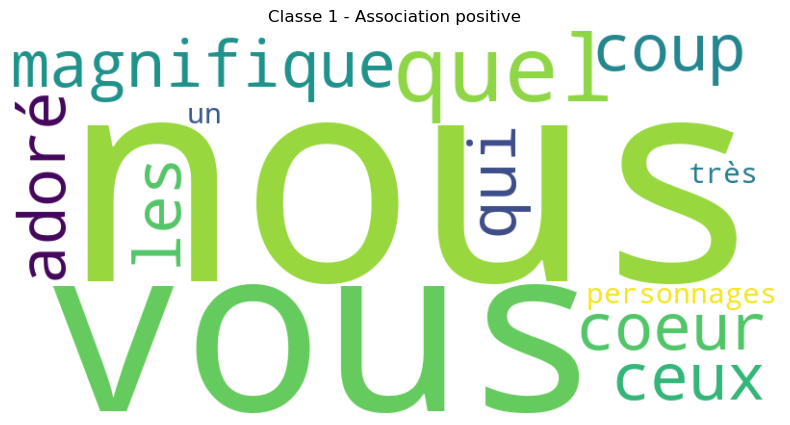

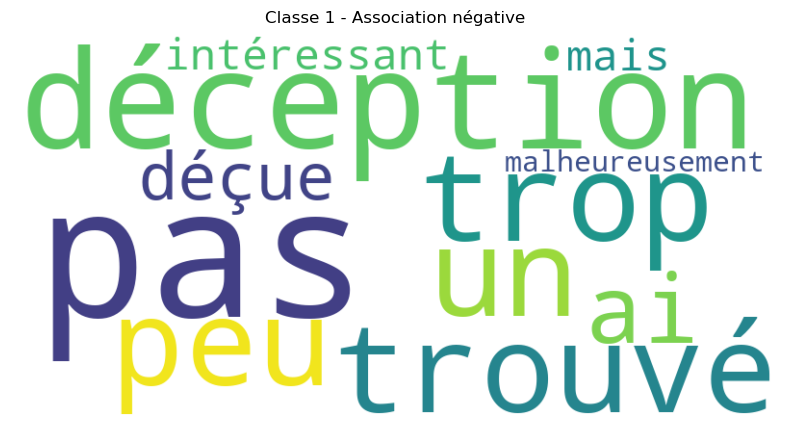

In [233]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Les listes de mots associ√©es √† chaque classe
mots_classe_pos_1 = ['nous','vous','quel','magnifique','coeur','coup','ador√©','ceux qui', 'les personnages','un tr√®s']
mots_classe_neg_1 = ['pas','d√©ception','trouv√©','trop','un peu','ai pas','d√©√ßue','int√©ressant', 'mais','malheureusement']

# Fonction pour g√©n√©rer le nuage de mots
def generer_wordcloud(mots, titre):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(mots))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(titre)
    plt.show()

# G√©n√©rer les nuages de mots pour chaque classe
generer_wordcloud(mots_classe_pos_1, "Classe 1 - Association positive")
generer_wordcloud(mots_classe_neg_1, "Classe 1 - Association n√©gative")


# 7. Conclusion

Notre projet a √©t√© une exp√©rience enrichissante. L'objectif √©tait de classifier les avis des lecteurs en 3 classes : positifs, neutres ou n√©gatifs.

Pour cela, nous avons effectuer diff√©rents traitements sur les avis, comme une lemmatisation ou encore un changement en entit√©s nomm√©es. Nous avons √©galement test√© plusieurs mod√®les afin de savoir lequel nous aurait donn√© la meilleure accuracy.

C'est donc en travaillant sur diff√©rents mod√®les et en manipulant diverses variables que nous avons constat√© que le mod√®le conservant les mots vides √©tait  plus performant dans notre contexte, compar√© √† celui qui les supprimait.

L'exploration des bigrammes s'est aussi av√©r√©e int√©ressante pour notre √©tude, les mots obtenus √† la fin √©taient globalement coh√©rents avec les classes, bien que certains aient sembl√©s d√©pourvus de sens.

Nous avons test√© nos mod√®les avec l'utilisation des entit√©s nomm√©es, mais les r√©sultats n'√©taient pas toujours coh√©rents avec la fonction print_n_strongest_features. Aussi, les accuracy √©taient proches des mod√®les avec la colonne "entit√© nomm√©e". C'est pourquoi nous avons d√©cid√© de ne pas les utiliser et de garder la colonne de donn√©es brutes "reader_review".

Cependant, nous pouvons faire quelques critiques concernant notre projet : 
- Nous devons reconna√Ætre qu'il y a des possibles biais dans notre matrice de confusion, notamment en raison de l'inclusion d'avis consid√©r√©s comme des "r√©sum√©s" de livres, class√©s √† tort comme non neutres dans notre base de donn√©es.
- Nous avons √©galement remarqu√© que nos mod√®les avaient tendance √† classer les avis comme positifs. Cela peut √™tre d√ª au fait que la base de donn√©es contient plus d'avis positifs que d'avis neutres ou n√©gatifs. Il apprend donc mieux √† classer les avis positifs que les autres. 

Ce genre de traitement peut √™tre tr√®s utile par exemple dans l'analyse de commentaire laiss√© par des consommateurs sur l'achat de certains produits. En effet, dans le cadre du marketing cela peut permettre de recommander des produits √† des clients en fonction de leurs avis sur d'autres produits. Cela peut √©galement permettre de faire des √©tudes de march√© sur les produits les plus appr√©ci√©s par les consommateurs.

Nous n'avons pas rencontr√© de probl√®me majeur qui nous a emp√™cher de continuer le travail. Nous nous sommes surtout pos√©es des questions sur la mani√®re de proc√©der pour certains traitements. Mais nous avons toujours fini par comprendre.

En conclusion, ce projet a √©t√© une exp√©rience enrichissante pour nous. En tant que passionn√©es de lecture, nous avons eu l'opportunit√© de red√©couvrir des livres d√©j√† lus et d'explorer de nouveaux ouvrages qui ont enrichi notre liste de lecture.üòä Cela nous a permis d'appliquer des statistiques dans le traitement du langage peuvent √™tre fascinantes et utiles.



# 7. Pour aller plus loin

- **Personnalisation et recommandations:** Dans les syst√®mes de recommandation, la reconnaissance des entit√©s nomm√©es peut aider √† comprendre les pr√©f√©rences des utilisateurs en identifiant les entit√©s (comme des films, des livres, des lieux) mentionn√©es dans leurs interactions textuelles.
- **Comparaison avec les notes** : Nous aurions pu faire une comparaison entre la polarit√© de l'avis et la note attribu√©e par le lecteur. Cela nous aurait permis de voir si les avis positifs sont toujours associ√©s √† une note √©lev√©e et inversement.